# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

In [2]:
#Initialize CUDA - must be first call to CUDA!
cuda_driver.init()

In [3]:
#Create CUDA context
cuda_device = cuda_driver.Device(0)
print("Using '{:s}'".format(cuda_device.name()))
print(" => compute capability: {:s}".format(str(cuda_device.compute_capability())))
context = cuda_device.make_context()
free, total = cuda_driver.mem_get_info()
print(" => memory: {:d} / {:d} MB available".format(int(free/(1024*1024)), int(total/(1024*1024))))

Using 'Tesla K80'
 => compute capability: (3, 7)
 => memory: 10212 / 11441 MB available


In [6]:
cuda_kernel = """
__global__ void addVectorKernel(float* c, float* a, float* b) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    c[i] = a[i] + b[i];
}
__global__ void addMatrixKernel(float* c, float* a, float* b, int cols) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;
    
    //Pseudocode
    //c[j][i] = a[j][i] + b[j][i]
    unsigned int k = j*cols + i;
    
    c[k] = a[k] + b[k];
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("addMatrixKernel");

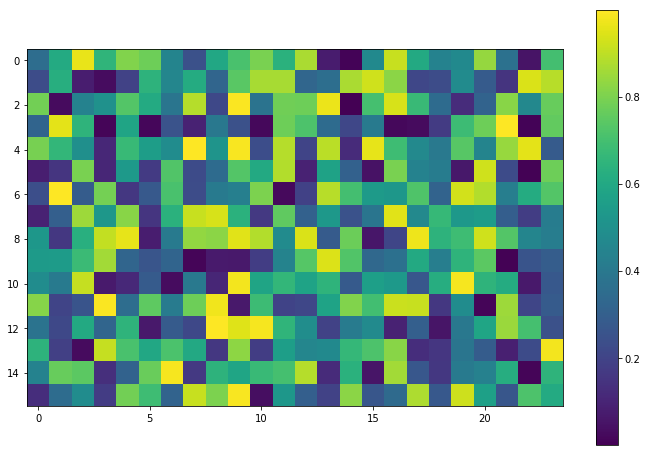

In [11]:
#Size of our test
test_size = (16, 24)

#Create test input / output data
a = np.random.random(test_size).astype(np.float32)
b = np.random.random(test_size).astype(np.float32)
c = np.empty_like(a)

fig = plt.figure(figsize=(12,8))
plt.imshow(a)
plt.colorbar()
plt.show()

In [12]:
print(a.shape)

(16, 24)


In [13]:
#Upload data to the device
a_g = GPUArray(a.shape, np.float32)
b_g = GPUArray(b.shape, np.float32)
a_g.set(a)
b_g.set(b)

In [14]:
#Allocate output data
c_g = GPUArray(c.shape, np.float32)

In [22]:
#a.shape = [rows, columns] => [y, x]
domain_size = (a.shape[1], a.shape[0]) #Now domain size = [x, y]
block_size = (8, 4, 1) #These need to be [x, y, z]
grid_size = (domain_size[0] // block_size[0], domain_size[1] // block_size[1], 1)

print("Domain_size is " + str(domain_size))
print("Block_size is " + str(block_size))
print("Grid_size is " + str(grid_size))

Domain_size is (24, 16)
Block_size is (8, 4, 1)
Grid_size is (3, 4, 1)


In [24]:
#Execute program on device
kernel(c_g, a_g, b_g, np.int32(domain_size[0]), block=block_size, grid=grid_size)

#Copy data from device to host
c_g.get(c)

array([[0.82425785, 1.3063028 , 1.1934574 , 0.6712711 , 1.6580148 ,
        1.7739623 , 0.92673373, 0.7710205 , 0.863724  , 0.9188934 ,
        1.2666498 , 1.0538803 , 1.2713938 , 0.43981427, 0.58323795,
        1.0399183 , 1.6472576 , 0.654047  , 0.9283961 , 1.2021201 ,
        1.1786699 , 1.0241377 , 1.0449497 , 1.5436366 ],
       [0.43262976, 1.4579455 , 0.7136212 , 0.5171683 , 0.60397404,
        1.2522228 , 0.9442873 , 0.7507281 , 0.8162148 , 1.298001  ,
        1.7912476 , 1.3927608 , 1.1585574 , 0.50003743, 1.2230288 ,
        1.083072  , 1.5864518 , 0.4845649 , 0.32669914, 1.3327875 ,
        0.80417526, 0.633654  , 1.548624  , 1.8194683 ],
       [1.1171598 , 0.13638063, 1.1322105 , 0.7850393 , 1.004755  ,
        1.4502498 , 0.5649321 , 1.182189  , 1.0362024 , 1.9429855 ,
        0.61295366, 1.2128248 , 0.8597044 , 1.3219403 , 0.84680563,
        1.4927504 , 1.7898815 , 1.3415761 , 0.89243925, 0.5061937 ,
        0.6713599 , 1.5148919 , 1.0924857 , 1.3566332 ],
       [0.909

In [25]:
#Compute reference using Numpy
c_ref = a + b

#Print result
print("C   = ", c)
print("Ref = ", c_ref)
print("Sad = ", np.sum(np.abs(c - c_ref)))

C   =  [[0.82425785 1.3063028  1.1934574  0.6712711  1.6580148  1.7739623
  0.92673373 0.7710205  0.863724   0.9188934  1.2666498  1.0538803
  1.2713938  0.43981427 0.58323795 1.0399183  1.6472576  0.654047
  0.9283961  1.2021201  1.1786699  1.0241377  1.0449497  1.5436366 ]
 [0.43262976 1.4579455  0.7136212  0.5171683  0.60397404 1.2522228
  0.9442873  0.7507281  0.8162148  1.298001   1.7912476  1.3927608
  1.1585574  0.50003743 1.2230288  1.083072   1.5864518  0.4845649
  0.32669914 1.3327875  0.80417526 0.633654   1.548624   1.8194683 ]
 [1.1171598  0.13638063 1.1322105  0.7850393  1.004755   1.4502498
  0.5649321  1.182189   1.0362024  1.9429855  0.61295366 1.2128248
  0.8597044  1.3219403  0.84680563 1.4927504  1.7898815  1.3415761
  0.89243925 0.5061937  0.6713599  1.5148919  1.0924857  1.3566332 ]
 [0.9094578  1.8346775  1.626907   0.2959229  1.1759131  0.41467625
  0.82893574 0.80897045 1.2451855  0.7246984  0.5290614  0.90544385
  1.4953939  1.1379282  0.34494752 0.6803453  0.

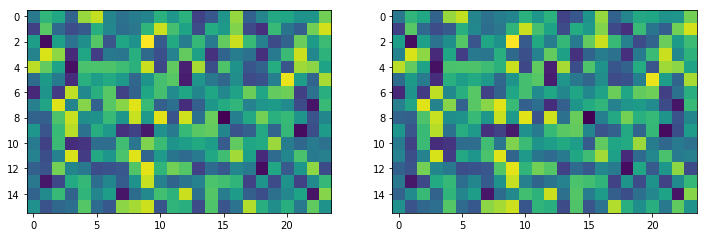

In [26]:
fig = plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(c)
plt.subplot(1,2,2)
plt.imshow(c_ref)